In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import os
import csv
import datetime as dt
import numpy as np
from sklearn.model_selection import RandomizedSearchCV

In [2]:
from network_analyze.utils import dateparse

DATA_DIR = Path('DATA')
dfile = DATA_DIR/'Wednesday-workingHours.pcap_ISCX.csv'
#dfile = DATA_DIR/'Tuesday-WorkingHours.pcap_ISCX.csv'
df = pd.read_csv(dfile, index_col=False, parse_dates=[' Timestamp'])
df = df.rename(columns=lambda x: x.strip())
#df = df[(df['Timestamp']> dt.datetime(2017,7,5,10, 10)) & (df['Timestamp'] < dt.datetime(2017,7,5,10,30))]
#df=df[(df['Label']!='DoS slowloris')]

In [3]:
from network_analyze.utils import dateparse


dateparse(str(df.head(1)['Timestamp']))

ValueError: time data '0   2017-05-07 08:42:00\nName: Timestamp, dtype: datetime64[ns]' does not match format '%d/%m/%Y %H:%M'

In [ ]:
#df[df.Label=='DoS slowloris'] 2017-07-05 09:48:00
df = df[(df['Timestamp']> dt.datetime(2017,7,5,9, 30)) & (df['Timestamp']< dt.datetime(2017,7,5,10, 30))]
#df = df[(df['Label'] == 'BENIGN')].head(2000)

In [ ]:
quant_cols =  ['Flow Duration',
       'Total Fwd Packets', 'Total Backward Packets',
       'Total Length of Fwd Packets', 'Total Length of Bwd Packets',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean', 'Fwd Packet Length Std',
       'Bwd Packet Length Max', 'Bwd Packet Length Min',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',   'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count',
       'URG Flag Count', 'CWE Flag Count', 'ECE Flag Count', 'Down/Up Ratio',
       'Average Packet Size', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size',
       'Fwd Header Length.1', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk',
       'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk',
       'Bwd Avg Bulk Rate', 'Subflow Fwd Packets', 'Subflow Fwd Bytes',
       'Subflow Bwd Packets', 'Subflow Bwd Bytes', 'Init_Win_bytes_forward',
       'Init_Win_bytes_backward', 'act_data_pkt_fwd', 'min_seg_size_forward','Active Mean', 'Active Std', 'Active Max', 'Active Min', 'Idle Mean',
       'Idle Std', 'Idle Max', 'Idle Min']

SELECTED_COLS = ["Bwd Packets/s", "Flow Packets/s", "Flow IAT Mean", "Flow IAT Mean", "Bwd IAT Max"]

In [519]:
from network_analyze.conf import QUANT_COLS
import fbpca
#na razie pomijam wartosci nan i inf
COLS = quant_cols + ['Label']
df = df[COLS]
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df[df.select_dtypes(include=[np.number]).ge(0).all(1)]
df = df.dropna()
#df = df[df['Label'] != 'BENIGN']
M = df.to_numpy()
Labels = M[:, -1]
M = M[:, :-1]
M_train, M_test, Labels_train, Labels_test = train_test_split(M, Labels, test_size=0.3, random_state=0)
#fbpca.pca(M, raw=True)
M = M.astype(float)

In [520]:
df.Label.unique()
df.groupby('Label')['Label'].count()

Label
BENIGN              9608
DoS Slowhttptest    1812
DoS slowloris          2
Name: Label, dtype: int64

In [521]:
import fbpca
TOL=1e-9
MAX_ITERS=3

def converged(Z, d_norm):
    err = np.linalg.norm(Z, 'fro') / d_norm
    print('error: ', err)
    return err < TOL

def shrink(M, tau):
    S = np.abs(M) - tau
    return np.sign(M) * np.where(S>0, S, 0)

def norm_op(M): return _svd(M, 1)[1][0]
def _svd(M, rank):
       return fbpca.pca(M, k=min(rank, np.min(M.shape)), raw=True)

def svd_reconstruct(M, rank, min_sv):
    u, s, v = _svd(M, rank)
    s -= min_sv
    nnz = (s > 0).sum()
    return u[:,:nnz] @ np.diag(s[:nnz]) @ v[:nnz], nnz

In [522]:
import numpy as np



def pcp(X, maxiter=10, k=10): # refactored
    m, n = X.shape
    trans = m<n
    if trans: X = X.T; m, n = X.shape

    lamda = 1/np.sqrt(m)
    op_norm = norm_op(X)
    Y = np.copy(X) / max(op_norm, np.linalg.norm( X, np.inf) / lamda)
    mu = k*1.25/op_norm; mu_bar = mu * 1e7; rho = k * 1.5

    d_norm = np.linalg.norm(X, 'fro')
    L = np.zeros_like(X); sv = 1

    examples = []

    for i in range(maxiter):
        print("rank sv:", sv)
        X2 = X + Y/mu

        # update estimate of Sparse Matrix by "shrinking/truncating": original - low-rank
        S = shrink(X2 - L, lamda/mu)

        # update estimate of Low-rank Matrix by doing truncated SVD of rank sv & reconstructing.
        # count of singular values > 1/mu is returned as svp
        L, svp = svd_reconstruct(X2 - S, sv, 1/mu)

        # If svp < sv, you are already calculating enough singular values.
        # If not, add 20% (in this case 240) to sv
        sv = svp + (1 if svp < sv else round(0.05*n))

        # residual
        Z = X - L - S
        Y += mu*Z; mu *= rho

        examples.extend([S[140,:], L[140,:]])

        if m > mu_bar: m = mu_bar
        if converged(Z, d_norm): break

    if trans: L=L.T; S=S.T
    return L, S, examples

In [523]:
def pcp(X, maxiter=10, k=10): # refactored
    m, n = X.shape
    trans = m<n
    if trans: X = X.T; m, n = X.shape

    lamda = 1/np.sqrt(m)
    op_norm = norm_op(X)
    Y = np.copy(X) / max(op_norm, np.linalg.norm( X, np.inf) / lamda)
    mu = k*1.25/op_norm; mu_bar = mu * 1e7; rho = k * 1.5

    d_norm = np.linalg.norm(X, 'fro')
    L = np.zeros_like(X); sv = 1

    examples = []

    for i in range(maxiter):
        print("rank sv:", sv)
        X2 = X + Y/mu

        # update estimate of Sparse Matrix by "shrinking/truncating": original - low-rank
        S = shrink(X2 - L, lamda/mu)

        # update estimate of Low-rank Matrix by doing truncated SVD of rank sv & reconstructing.
        # count of singular values > 1/mu is returned as svp
        L, svp = svd_reconstruct(X2 - S, sv, 1/mu)

        # If svp < sv, you are already calculating enough singular values.
        # If not, add 20% (in this case 240) to sv
        sv = svp + (1 if svp < sv else round(0.05*n))

        # residual
        Z = X - L - S
        Y += mu*Z; mu *= rho

        examples.extend([S[140,:], L[140,:]])

        if m > mu_bar: m = mu_bar
        if converged(Z, d_norm): break

    if trans: L=L.T; S=S.T
    return L, S, examples

In [524]:
from sklearn.preprocessing import StandardScaler

# M = df.to_numpy()
# M = M[~np.isnan(M).any(axis=1), :]
# M = M[~np.isinf(M).any(axis=1), :]
stc = StandardScaler()
M_s = stc.fit_transform(M)
fL, S, examples =  pcp(M, maxiter=100, k=47)

rank sv: 1
error:  0.02275690226350009
rank sv: 5
error:  0.0004451012913801452
rank sv: 5
error:  7.240554954934163e-06
rank sv: 9
error:  1.2676571706319222e-07
rank sv: 13
error:  1.4115625176851157e-09
rank sv: 17
error:  9.429036809204263e-12


In [525]:
df.groupby(['Label'])['Label'].count()

Label
BENIGN              9608
DoS Slowhttptest    1812
DoS slowloris          2
Name: Label, dtype: int64

In [526]:
S

array([[ 2.08486971e+06, -2.69571955e+00, -7.24640705e+00, ...,
        -5.08382284e+04, -3.88772190e+05, -3.88772190e+05],
       [ 7.47792780e+05, -3.60452825e+00, -7.11784227e+00, ...,
        -1.26537907e+04, -1.33085818e+05, -1.33085818e+05],
       [ 1.50642896e+06, -4.27787322e-01, -3.44103801e+00, ...,
        -4.35065511e+04, -3.30665108e+05, -3.30665108e+05],
       ...,
       [-2.44877476e+02,  5.39299237e-02,  1.46822862e-01, ...,
         1.16256324e+02,  2.49602196e+02,  2.49602196e+02],
       [-5.23418594e+01,  1.59512319e+00,  1.60573475e-01, ...,
         2.29461016e-01,  4.06770681e+01,  4.06770681e+01],
       [ 1.53127640e+04, -1.23871244e+00, -4.24552138e-01, ...,
         8.73476543e+02, -1.90659173e+03, -1.90659173e+03]])

In [527]:
from network_analyze.rpca import R_pca
rpca = R_pca(M_s)
L, S = rpca.fit(max_iter=10000, iter_print=100)

iteration: 1, error: 0.18425676030322632
iteration: 100, error: 0.003700425401218279
iteration: 200, error: 0.003126828566787836
iteration: 300, error: 0.002765203184789247
iteration: 400, error: 0.0020722542930895465
iteration: 500, error: 0.0019267265351468924
iteration: 600, error: 0.0020556844756875283
iteration: 700, error: 0.0019102018830820884
iteration: 800, error: 0.0021926164381292717
iteration: 900, error: 0.0014999287729172337
iteration: 1000, error: 0.0014214596640294342
iteration: 1100, error: 0.0011662651813991241
iteration: 1200, error: 0.0014685506754287358
iteration: 1300, error: 0.0010857604196497666
iteration: 1400, error: 0.0012098626077506499
iteration: 1500, error: 0.0014993115944976474
iteration: 1600, error: 0.0013682924543250781
iteration: 1700, error: 0.0012388375730365126
iteration: 1800, error: 0.0012865551058690572
iteration: 1900, error: 0.0012700749954361907
iteration: 2000, error: 0.0015663547407368324
iteration: 2100, error: 0.0020139192678743584
itera

In [528]:
np.min(S)

-2.259766243683405

In [529]:
from pandas import DataFrame


output = DataFrame(np.vstack((np.linalg.norm(S
, axis=1, ord=1), Labels)).T, columns = ['suma', 'label'])
# output = DataFrame(np.vstack((np.linalg.norm(np.where(S>0.1, S, 0)
# , axis=1, ord=1), Labels)).T, columns = ['suma', 'label'])

output = DataFrame(np.vstack((np.max(S, axis=1), Labels)).T, columns = ['suma', 'label'])

In [530]:
S[S>1]

array([1.11722852, 3.42284404, 1.93014336, ..., 4.3836706 , 1.35963796,
       1.6865716 ])

In [531]:
output[(output.label!='BENIGN')]

,suma,label
6797,4.889407,DoS slowloris
6798,4.889381,DoS slowloris
6799,0.844596,DoS Slowhttptest
6800,1.453307,DoS Slowhttptest
6801,1.452572,DoS Slowhttptest
...,...,...
8606,1.762418,DoS Slowhttptest
8607,39.747583,DoS Slowhttptest
8608,60.803117,DoS Slowhttptest
8609,5.421085,DoS Slowhttptest


<AxesSubplot: xlabel='label', ylabel='suma'>

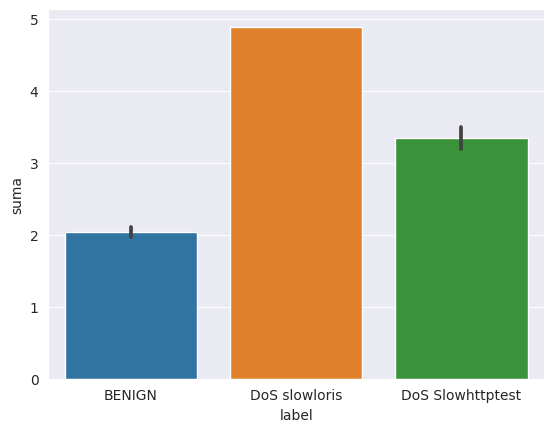

In [532]:
import seaborn as sns
sns.barplot(data=output, x='label', y='suma')

In [533]:
np.linalg.matrix_rank(L)

35

In [539]:
output[(output['suma'] >2)].groupby(['label'])['label'].count()

label
BENIGN              2673
DoS Slowhttptest     940
DoS slowloris          2
Name: label, dtype: int64

In [540]:
output.groupby(['label'])['label'].count()

label
BENIGN              9608
DoS Slowhttptest    1812
DoS slowloris          2
Name: label, dtype: int64

In [498]:
output1 = DataFrame(S, columns=QUANT_COLS)

In [499]:
output1['label'] = Labels

In [500]:
output3 = []
for i,x in output1.iterrows():

    for stat in QUANT_COLS:

        output3.append([stat, x[stat], x['label']])

df_3 = DataFrame(output3, columns=['stat', 'value', 'label'])

In [501]:
output1

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,label
0,-2.980542e-07,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.000000,0.000000e+00,...,0.218752,-4.718682e-07,-0.0,0.000000,-0.000000e+00,-0.0,-0.0,0.000000e+00,-0.0,FTP-Patator
1,-6.230416e-07,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,0.000000,0.000000e+00,...,0.218771,-0.000000e+00,-0.0,0.000000,-0.000000e+00,0.0,0.0,-0.000000e+00,-0.0,FTP-Patator
2,0.000000e+00,0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.000000,0.000000e+00,...,0.263475,0.000000e+00,0.0,-0.000000,-0.000000e+00,-0.0,0.0,-0.000000e+00,0.0,FTP-Patator
3,2.084520e-05,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.000000,-7.237757e-07,...,0.248896,-0.000000e+00,0.0,0.000000,-0.000000e+00,-0.0,0.0,-0.000000e+00,0.0,FTP-Patator
4,-1.235820e-06,-0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.000000,1.277614e-07,...,0.218858,0.000000e+00,-0.0,-0.000000,-0.000000e+00,-0.0,0.0,-0.000000e+00,0.0,FTP-Patator
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6856,0.000000e+00,0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,0.000000,0.000000e+00,...,0.272156,0.000000e+00,-0.0,-0.000001,0.000000e+00,0.0,0.0,-0.000000e+00,0.0,BENIGN
6857,0.000000e+00,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.000000,-0.000000e+00,...,-1.226414,-3.572004e-07,-0.0,-0.000000,0.000000e+00,0.0,-0.0,-0.000000e+00,-0.0,BENIGN
6858,0.000000e+00,0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.000000,-0.000000e+00,...,0.256838,0.000000e+00,0.0,0.000000,-0.000000e+00,-0.0,0.0,-0.000000e+00,0.0,BENIGN
6859,-2.987635e-07,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.000000,0.000000e+00,...,0.218752,-4.715927e-07,-0.0,0.000000,-0.000000e+00,-0.0,-0.0,0.000000e+00,-0.0,BENIGN


<AxesSubplot: xlabel='stat', ylabel='value'>

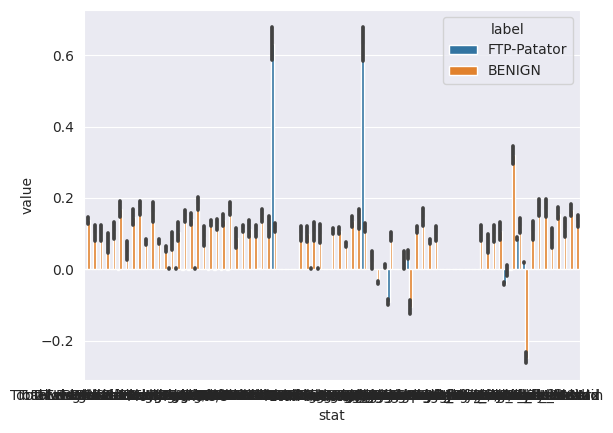

In [502]:
import seaborn as sns

sns.barplot(data=df_3, x = 'stat', y = 'value', hue='label')



In [503]:
df_3.groupby('stat')['value'].mean().sort_values()

stat
min_seg_size_forward      -0.207816
Down/Up Ratio             -0.082953
PSH Flag Count            -0.030619
Init_Win_bytes_forward    -0.008301
Min Packet Length          0.000000
                             ...   
Active Std                 0.146690
Flow IAT Max               0.156605
SYN Flag Count             0.194771
Fwd PSH Flags              0.194771
Init_Win_bytes_backward    0.271486
Name: value, Length: 77, dtype: float64

In [504]:
Init_Win_bytes_forward     0.137349
Fwd PSH Flags              0.147298
SYN Flag Count             0.147298
Min Packet Length          0.229221
Init_Win_bytes_backward    0.251420

SyntaxError: invalid syntax (2462970370.py, line 1)

In [505]:
y_pred = []
y_true = []
for idx, data in output.iterrows():
    attack_pred = "attack" if data["suma"] <1 else "benign"
    attack_true = "attack" if data["label"] != "BENIGN" else "benign"
    y_pred.append(attack_pred)
    y_true.append(attack_true)
y_pred

['benign',
 'benign',
 'benign',
 'benign',
 'benign',
 'benign',
 'benign',
 'benign',
 'benign',
 'benign',
 'benign',
 'benign',
 'benign',
 'benign',
 'benign',
 'attack',
 'attack',
 'attack',
 'attack',
 'attack',
 'attack',
 'benign',
 'attack',
 'benign',
 'attack',
 'attack',
 'attack',
 'benign',
 'benign',
 'benign',
 'attack',
 'attack',
 'attack',
 'attack',
 'attack',
 'attack',
 'benign',
 'benign',
 'attack',
 'benign',
 'benign',
 'attack',
 'attack',
 'attack',
 'benign',
 'benign',
 'benign',
 'attack',
 'attack',
 'attack',
 'attack',
 'benign',
 'attack',
 'attack',
 'benign',
 'attack',
 'benign',
 'benign',
 'attack',
 'attack',
 'attack',
 'benign',
 'benign',
 'benign',
 'attack',
 'attack',
 'attack',
 'attack',
 'attack',
 'attack',
 'benign',
 'attack',
 'benign',
 'benign',
 'attack',
 'attack',
 'attack',
 'benign',
 'benign',
 'benign',
 'attack',
 'attack',
 'attack',
 'attack',
 'attack',
 'attack',
 'benign',
 'benign',
 'benign',
 'attack',
 'benign',

In [506]:
from sklearn.metrics import precision_recall_fscore_support

precision_recall_fscore_support(y_true, y_pred, average='binary', pos_label='attack')

(0.9983633387888707, 0.5888030888030888, 0.7407407407407408, None)

In [507]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred)

0.9377641743186125